# Lab course: Computational statistical mechanics

# 1. Machine learning of the simple Ising model in 2D

## 1.1 Code for a MC Ising simulation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
import pandas as pd

### *Initialization and calculation of the Energy difference*

In [2]:
@njit
def init(n=10, random=False):
    grid = np.zeros(shape=(n,n), dtype = np.int64)
    if random:
        grid = np.random.randint(0,2,size = (n,n))
    grid = np.where(grid==0,-1,grid)
    return grid

In [3]:
@njit
def calculate_energy_diff(x,grid,J=1,B=0):
    H = np.zeros(2)
    y = np.where(x==grid.shape[0]-1,-1,x)
    j = 1
    for i in range(2):
        S = 0
        S+= grid[x[0],x[1]]*grid[x[0]-1,x[1]]*j
        S+= grid[x[0],x[1]]*grid[y[0]+1,x[1]]*j
        S+= grid[x[0],x[1]]*grid[x[0],x[1]-1]*j
        S+= grid[x[0],x[1]]*grid[x[0],y[1]+1]*j
        H[i] = S
        j = -1
    H_diff = -J*(H[1] - H[0])+ B*2*grid[x[0],x[1]]
    return H_diff

###  *Monte Carlo simulation*

In [4]:
@njit
def spin_flip(grid, T, J ,B):
    M_diff = 0
    x = np.random.randint(0,grid.shape[0],size=2)
    H_diff = calculate_energy_diff(x,grid, J, B)
    if T == 0:
        if H_diff <= 0:
            grid[x[0],x[1]] = grid[x[0],x[1]]*-1
            M_diff = grid[x[0],x[1]]*-2
          
    else:
        r = np.random.random()
        if r < np.exp(-H_diff/T):
            grid[x[0],x[1]] = grid[x[0],x[1]]*-1
            M_diff = grid[x[0],x[1]]*-2

    return M_diff

### *Functions to calculate the data for the plots*

In [5]:
@njit
def m_of_t(steps, T, N, random, J, B, val = 1):
    M = np.zeros(steps)
    grid = init(N, random)
    grid = grid * val
    M[0] = np.sum(grid)/N**2
    for j in range(1,steps):
        M_diff = spin_flip(grid,T, J, B)
        M[j] = M[j-1] - M_diff/N**2
    return M, grid

In [6]:
@njit
def m_of_Temp(T, N, steps, equi, J, B, random = True):
    M_of_T = np.zeros(T.size)
    for i in range(T.size):
        M = np.abs(m_of_t(steps, T[i], N, random, J, B)[0])
        M_of_T[i] = np.mean(M[equi:])
    return M_of_T

In [7]:
@njit
def m_of_B(T, N, steps, equi, J, B, both = True, random = True):
    M_of_B = np.zeros((2,B.size))
    for i in range(B.size):
        M = m_of_t(steps, T, N, random, J, B[i])[0]
        M_of_B[0,i] = np.mean(M[equi:])
    if both:
        for i,j in enumerate(B,0):
            M = m_of_t(steps, T, N, random, J, j, val = -1)[0]
            M_of_B[1,i] = np.mean(M[equi:])
    return M_of_B

In [8]:
@njit
def susceptibility(N,T,steps, equi, B=0, J=1,random = True):
    susc = np.zeros(T.size)
    for i in range(T.size):
        M = m_of_t(steps, T[i], N, random, J, B)[0]
        susc[i] = 1/T[i]*(np.mean(M[equi:]**2)-np.mean(M[:equi])**2)
    return susc

In [9]:
@njit
def create_set(n : int, T : np.array, N : int, steps, J = 1):
    label = np.zeros((n*T.shape[0],3))
    grid = np.zeros((1,N**2), dtype = np.int64)
    for i in range(T.shape[0]*n):
        m = m_of_t(steps, T[int(i/n),0], N, True, J, 0, val = 1)[1].flatten()
        m = np.expand_dims(m,0)
        grid = np.vstack((grid,m))
        label[i] = T[int(i/n)]
    return grid,label

In [10]:
def plot_m(steps, T, N, random, J, B):
    """
    Plots M as a function of the timesteps t.
    """
    M, grid  = m_of_t(steps, T, N, random, J, B)
    steps = M.size
    fig, ax = plt.subplots()
    ax.plot(np.arange(0,steps,1), M,'-.')
    ax.set_xlabel('Steps t')
    ax.set_ylabel('Magnetization M')
    ax.set_title(f'Magnetization M(t)')
    plt.show()
    return grid

## 1.2 Magnetization of timesteps

In [12]:
# System parameters:
N = 10
random_config = True
n_systems = 6
B = 0.
J = 1
kT = 0
steps = 5000

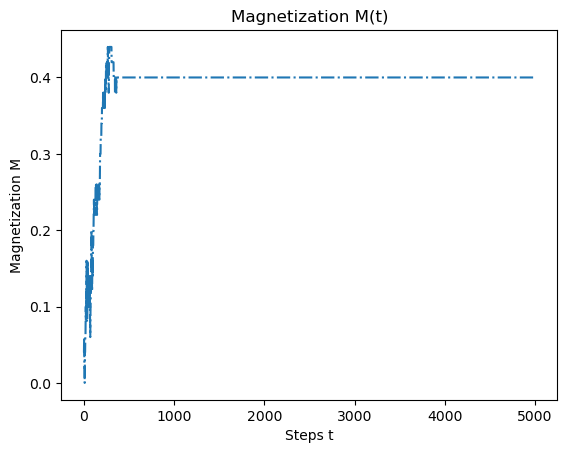

In [15]:
grid = plot_m(steps, kT, N, random_config, J, B)

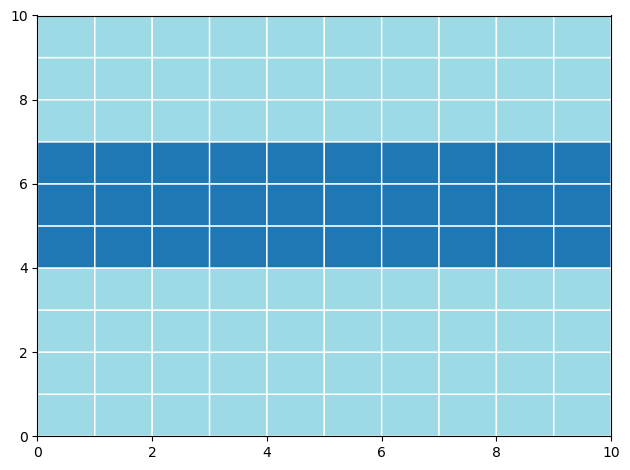

In [17]:
fig, ax= plt.subplots()
c = ax.pcolor(grid, edgecolors='white', linewidths=1, cmap='tab20')
#ax.set_title('Visualization of the 2D Ising grid')
#plt.gca().axes.get_yaxis().set_visible(False)
#plt.gca().axes.get_xaxis().set_visible(False)
fig.tight_layout()
plt.show()

## 1.3 Magnetization of Temperature

Calculated with following approach: <br>
T = np.linspace(1.8,3.5,20) <br>
N = 64 <br>
steps = 40000000 <br>
equi = 20000000 <br>
J = 1 <br>
B = 0 <br>
<br>
m = m_of_Temp(T,N,steps,equi,J,B) <br>

In [11]:
data_64 = np.loadtxt("Data/Revising_64N_M_of_T.csv",skiprows = 1, delimiter=",")
data_32 = np.loadtxt("Data/Revising_32N_M_of_T.csv",skiprows = 1, delimiter=",")
data_16 = np.loadtxt("Data/Revision_16N_M_of_T.csv",skiprows = 1, delimiter=",")
calc_64 = np.loadtxt("N64calculated.csv", skiprows = 1, delimiter=",")
calc_32 = np.loadtxt("N32calculated.csv", skiprows = 1, delimiter=",")
calc_16 = np.loadtxt("N16calculated.csv", skiprows = 1, delimiter=",")

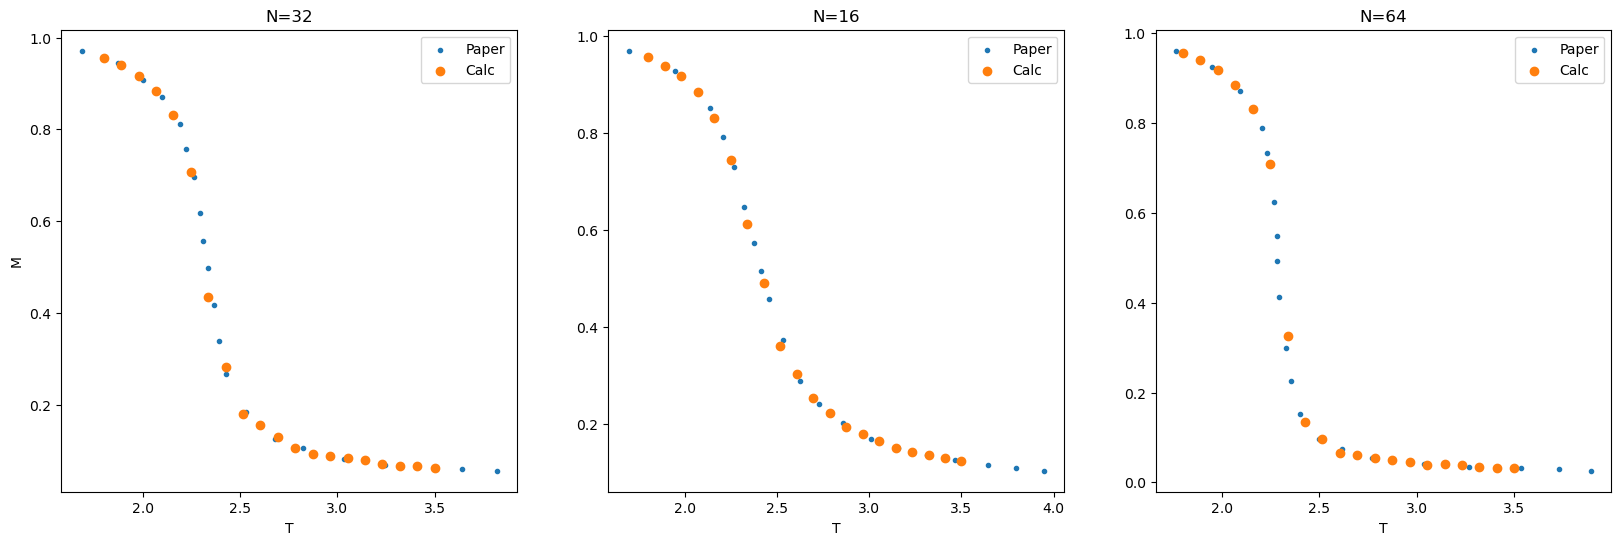

In [12]:
fig,ax = plt.subplots(1,3, figsize = (20,6))
ax[0].scatter(data_32[:,0],data_32[:,1], label = "Paper", marker = ".")
ax[1].scatter(data_16[:,0],data_16[:,1], label = "Paper", marker = ".")
ax[2].scatter(data_64[:,0],data_64[:,1], label = "Paper", marker = ".")
ax[0].scatter(calc_32[:,2],calc_32[:,1], label = "Calc")
ax[1].scatter(calc_16[:,2],calc_16[:,1], label = "Calc")
ax[2].scatter(calc_64[:,2],calc_64[:,1], label = "Calc")
ax[0].set_xlabel("T")
ax[1].set_xlabel("T")
ax[2].set_xlabel("T")
ax[0].set_title("N=32")
ax[1].set_title("N=16")
ax[2].set_title("N=64")
ax[0].set_ylabel("M")
ax[0].legend()
ax[1].legend()
ax[2].legend()
plt.show()

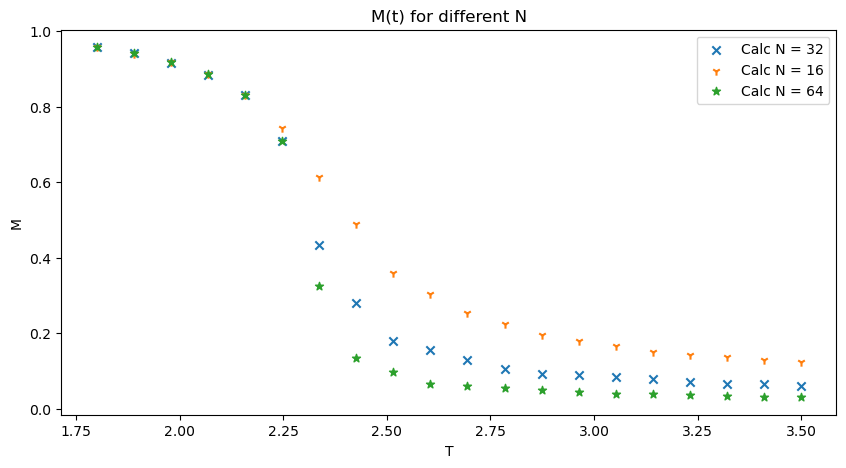

In [15]:
fig, ax = plt.subplots(1, figsize = (10,5))

ax.scatter(calc_32[:,2],calc_32[:,1], label = "Calc N = 32", marker = "x")
ax.scatter(calc_16[:,2],calc_16[:,1], label = "Calc N = 16", marker = "1")
ax.scatter(calc_64[:,2],calc_64[:,1], label = "Calc N = 64", marker = "*")
ax.legend()
ax.set_xlabel("T")
ax.set_ylabel("M")
ax.set_title("M(t) for different N")


plt.show()

## 1.4 Magnetization of magnetic field B

In [58]:
T = 1.8
N = 30
J = 1 
B = np.linspace(-0.5,0.5,20)
steps = 100000
equi = 30000

m_of_b1 = m_of_B(T,N,steps,equi,J,B,both = True, random = False)
m_of_b2 = m_of_B(T,N,steps,equi,J,B,both = True, random = True)

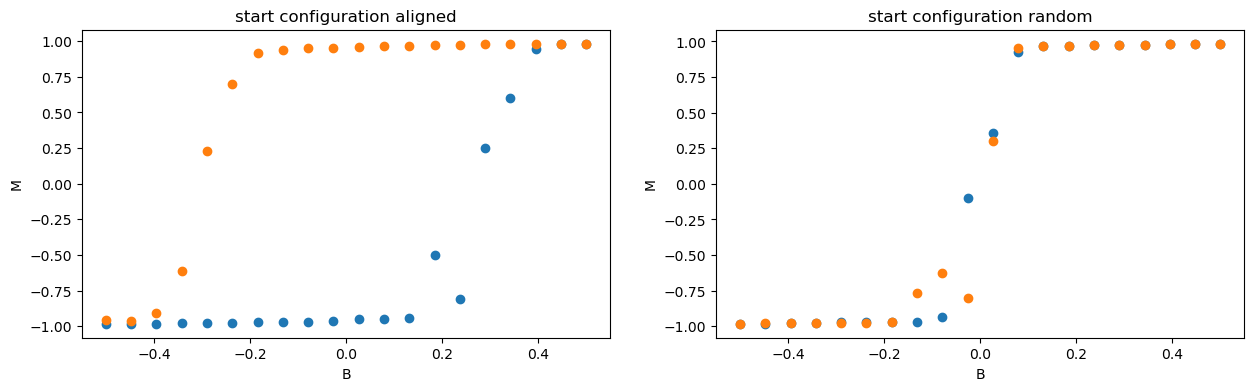

In [59]:
fig, ax = plt.subplots(1,2,figsize=(15,4))
ax[0].set_title("start configuration aligned")
ax[0].set_xlabel("B")
ax[0].set_ylabel("M")
ax[0].scatter(B,m_of_b1[0])
ax[0].scatter(B,m_of_b1[1])
ax[1].set_title("start configuration random")
ax[1].set_xlabel("B")
ax[1].set_ylabel("M")
ax[1].scatter(B,m_of_b2[0])
ax[1].scatter(B,m_of_b2[1])
plt.show()

dfx = pd.DataFrame(B,m_of_b)
dfx.to_csv('m_of_b.csv', mode='w', index=False, header=True)

## 1.4 Hist and free energy

In [19]:
# Initialization variables
N = 10 # For small N
T = 2.5 # T not too small
random = True
J = 1
B = 0
steps = 20000000
equi = 10000000

# Running the simulation
m = m_of_t(steps, T, N, random, J, B, val = 1)[0]

In [32]:
# creating the histogram
bins = np.linspace(-1, 1, 100)
bin_centers = (bins[:-1] + bins[1:]) / 2

density, bin_edges = np.histogram(m, bins, density = True)
free_energy = -np.log(density)

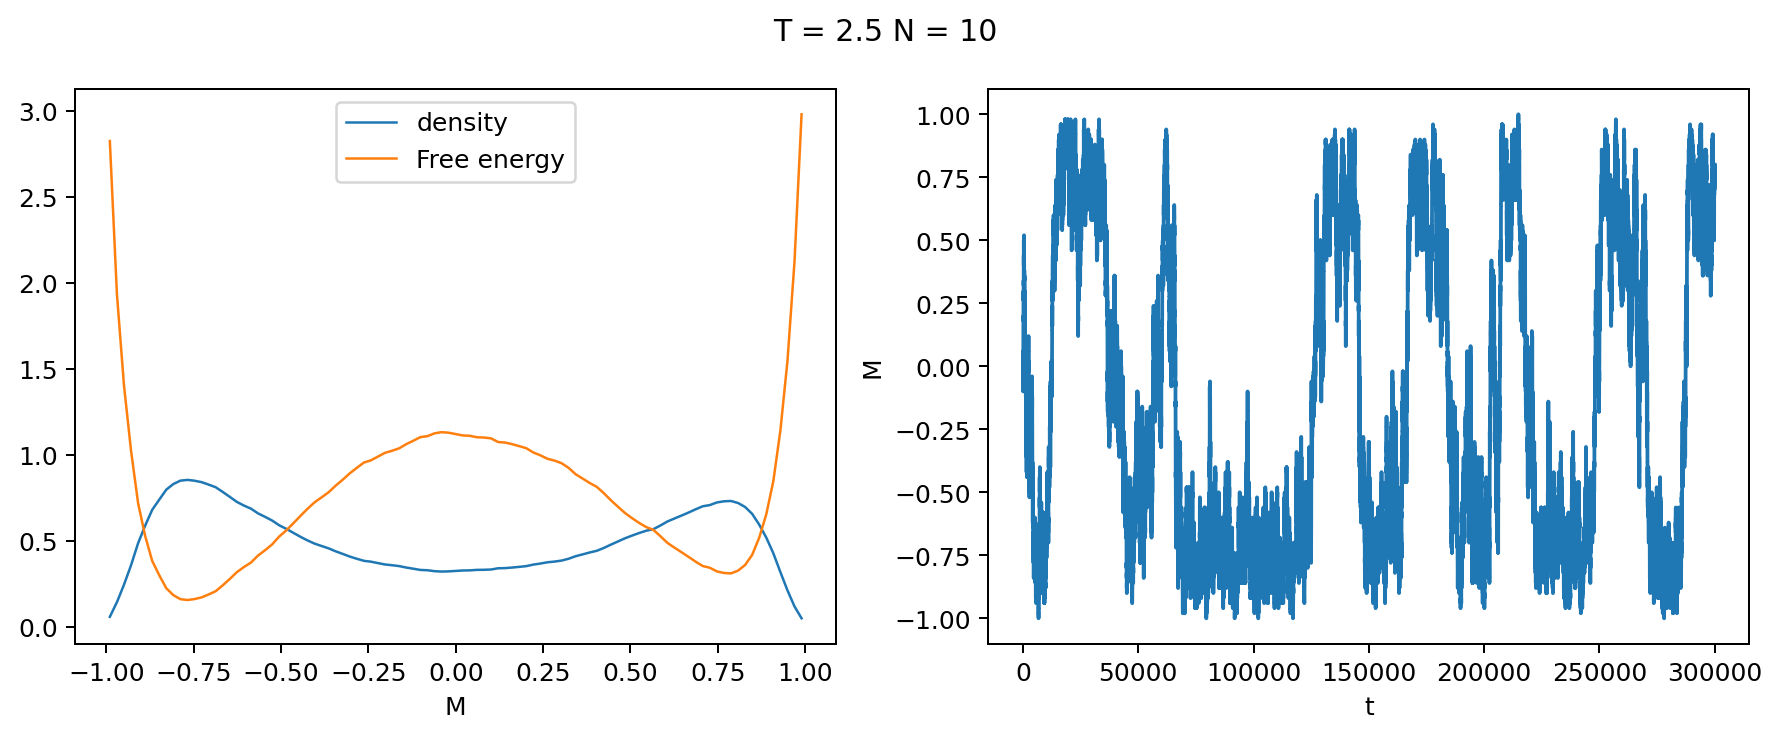

In [33]:
# Plotting
fig, ax = plt.subplots(1,2, figsize=(12,4), dpi=180)

ax[1].plot(np.arange(0,steps,1)[:300000],m[:300000])
ax[1].set_xlabel("t")
ax[1].set_ylabel("M")


ax[0].plot(bin_centers, density, lw=1, label='density')
ax[0].plot(bin_centers, free_energy, lw=1, label='Free energy')
ax[0].set_xlabel("M")
ax[0].legend()


fig.suptitle(f"T = {T} N = {N}")
plt.show()

# 2. Machine Learning of the Ising Model

## 2.1 Introduction and computation of sets

The following parameters were taken from the paper 'A high-bias, low-variance introduction to Machine Learning
for physicists' <br> (https://www.sciencedirect.com/science/article/pii/S0370157319300766?via%3Dihub) <br><br>
Considering a 40x40 square Lattice. $\newline$
Preparing $10^4$ states at every fixed temperature. (current 600) (200,600,1200) $\newline$
0 if the state is disordered and 1 if it is ordered. $\newline$
T/J < 2.0 ordered $\newline$
T/J > 2.5 disordered $\newline$
2.0 < T/J < 2.5 near critical$\newline$

In [11]:
N = 40 #40
T = np.linspace(0.25,4.0,16)#16
J = 1
B = 0
steps = 1000000
n = 600
print(f'Temperatures used:\n{T}')

Temperatures used:
[0.25 0.5  0.75 1.   1.25 1.5  1.75 2.   2.25 2.5  2.75 3.   3.25 3.5
 3.75 4.  ]


### *Creation of sets*

In [159]:
# ordered set
T = np.array([[0.25, 0, 1],[0.5, 1, 1],[0.75, 2, 1],[1., 3, 1],[1.25, 4, 1],[1.5, 5, 1],[1.75, 6, 1]])
ordered_X, ordered_Y = create_set(n, T, N, steps, J = 1) 
ordered_X = np.delete(ordered_X,0,0)

In [168]:
# critical set
T = np.array([[2, 7, 1],[2.25,8,1],[2.5,9,0]])
critical_X, critical_Y = create_set(n, T, N, steps, J = 1)
critical_X = np.delete(critical_X,0,0)

In [28]:
# disordered set
T = np.array([[2.75, 10, 0],[3,11,0],[3.25, 12, 0],[3.5, 13, 0],[3.75, 14, 0],[4, 15, 0]])
disordered_X, disordered_Y = create_set(n, T, N, steps, J = 1) 
disordered_X = np.delete(disordered_X,0,0)

### *Reading and plot of the data*

In [12]:
ordered_X = np.array(pd.read_csv("ordered_X3.csv"))
ordered_Y = np.array(pd.read_csv("ordered_Y2.csv"))
critical_X = np.array(pd.read_csv("critical_X3.csv"))
critical_Y = np.array(pd.read_csv("critical_Y2.csv"))
disordered_X = np.array(pd.read_csv("disordered_X2.csv"))
disordered_Y = np.array(pd.read_csv("disordered_Y2.csv"))

In [13]:
ordered_X.shape[0]/7

5400.0

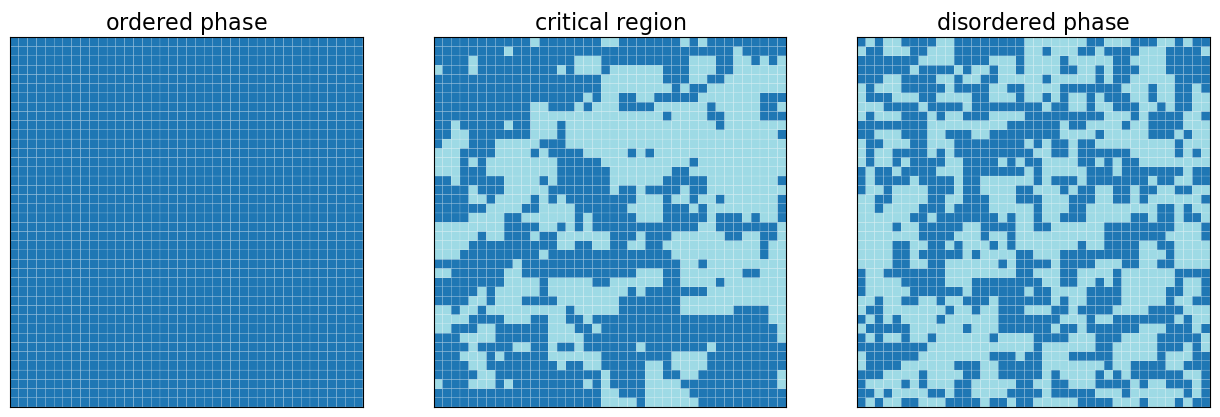

In [19]:
##### plot a few Ising states
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# set colourbar map
cmap_args=dict(cmap='tab20')

# plot states
fig, axarr = plt.subplots(nrows=1, ncols=3)

#axarr[0].imshow(ordered_X[500].reshape(N,N),**cmap_args)
axarr[0].pcolor(ordered_X[500].reshape(N,N), edgecolors='white', linewidths=0.1, cmap='tab20')
axarr[0].set_title('$\\mathrm{ordered\\ phase}$',fontsize=16)
axarr[0].tick_params(labelsize=16)

axarr[0].get_yaxis().set_visible(False)
axarr[0].get_xaxis().set_visible(False)

#axarr[1].imshow(critical_X[400].reshape(N,N),**cmap_args)
axarr[1].pcolor(critical_X[1200].reshape(N,N), edgecolors='white', linewidths=0.1, cmap='tab20')
axarr[1].set_title('$\\mathrm{critical\\ region}$',fontsize=16)
axarr[1].tick_params(labelsize=16)

axarr[1].get_yaxis().set_visible(False)
axarr[1].get_xaxis().set_visible(False)

#im=axarr[2].imshow(disordered_X[1000].reshape(N,N),**cmap_args)
axarr[2].pcolor(disordered_X[3102].reshape(N,N), edgecolors='white', linewidths=0.1, cmap='tab20')
axarr[2].set_title('$\\mathrm{disordered\\ phase}$',fontsize=16)
axarr[2].tick_params(labelsize=16)

axarr[2].get_yaxis().set_visible(False)
axarr[2].get_xaxis().set_visible(False)

fig.subplots_adjust(right=2.0)

plt.show()

## 2.2 Logistic regression with $y_i = \{0,1\}$<br>

In this part we would like to use a binary machine learning model to predict weither the given state is ordered (1) or unordered (0). <br>
As a model we use logistic regression. The cross entropy then gets solved with an SGD (stochastic gradient descent) and a linear approach.

At first we look at the regularization parameter $\lambda$ and how it affects SGD and the linear solver.

Then we would like to see what role the size of the training/test sets plays in the accuracy of the logistic regression.

### *Effects of the regularisation parameter $\lambda$ on SGD and linear solver*

In [14]:
###### apply logistic regression
from sklearn import linear_model
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

In [15]:
# define training and test data sets
X=np.concatenate((ordered_X,disordered_X))
Y=np.concatenate((ordered_Y[:,2],disordered_Y[:,2]))

In [16]:
###### define ML parameters
num_classes=2
train_to_test_ratio=0.5 # training samples

# pick random data points from ordered and disordered states 
# to create the training and test sets
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,train_size=train_to_test_ratio,test_size=1.0-train_to_test_ratio)
#Y_train = np.reshape(Y_train,(1300))

In [17]:
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(critical_X.shape[0], 'critical samples')
print(X_test.shape[0], 'test samples')

X_train shape: (35100, 1600)
Y_train shape: (35100,)

35100 train samples
16200 critical samples
35100 test samples


In [18]:
# define regularisation parameter
lmbdas=np.logspace(-5,5,11)

# preallocate data
train_accuracy=np.zeros(lmbdas.shape,np.float64)
test_accuracy=np.zeros(lmbdas.shape,np.float64)
critical_accuracy=np.zeros(lmbdas.shape,np.float64)

train_accuracy_SGD=np.zeros(lmbdas.shape,np.float64)
test_accuracy_SGD=np.zeros(lmbdas.shape,np.float64)
critical_accuracy_SGD=np.zeros(lmbdas.shape,np.float64)

In [19]:
# loop over regularisation strength
for i,lmbda in enumerate(lmbdas):

    # define logistic regressor
    logreg=linear_model.LogisticRegression(C=1.0/lmbda,random_state=1,verbose=0,max_iter=1000,tol=1E-5,
                                           solver='liblinear')

    # fit training data
    logreg.fit(X_train, Y_train)

    # check accuracy
    train_accuracy[i]=logreg.score(X_train,Y_train)
    test_accuracy[i]=logreg.score(X_test,Y_test)
    critical_accuracy[i]=logreg.score(critical_X,critical_Y[:,2])
 

   
    print('accuracy: train, test, critical')
    print('liblin: %0.4f, %0.4f, %0.4f' %(train_accuracy[i],test_accuracy[i],critical_accuracy[i]) )

    # define SGD-based logistic regression
    logreg_SGD = linear_model.SGDClassifier(loss='log_loss', penalty='l2', alpha=lmbda, max_iter=400, 
                                           shuffle=True, random_state=1, learning_rate='optimal')#100

    # fit training data
    logreg_SGD.fit(X_train,Y_train)

    # check accuracy
    train_accuracy_SGD[i]=logreg_SGD.score(X_train,Y_train)
    test_accuracy_SGD[i]=logreg_SGD.score(X_test,Y_test)
    critical_accuracy_SGD[i]=logreg_SGD.score(critical_X,critical_Y[:,2])
    
    print('SGD: %0.4f, %0.4f, %0.4f' %(train_accuracy_SGD[i],test_accuracy_SGD[i],critical_accuracy_SGD[i]) )

    print('finished computing %i/11 iterations' %(i+1))

accuracy: train, test, critical
liblin: 0.7518, 0.6972, 0.6062


/usr/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


SGD: 0.5028, 0.4682, 0.5056
finished computing 1/11 iterations
accuracy: train, test, critical
liblin: 0.7518, 0.6972, 0.6062
SGD: 0.5231, 0.4816, 0.5423
finished computing 2/11 iterations
accuracy: train, test, critical
liblin: 0.7518, 0.6972, 0.6062
SGD: 0.5217, 0.4676, 0.5543
finished computing 3/11 iterations
accuracy: train, test, critical
liblin: 0.7518, 0.6972, 0.6062
SGD: 0.7493, 0.6949, 0.6115
finished computing 4/11 iterations
accuracy: train, test, critical
liblin: 0.7518, 0.6972, 0.6062
SGD: 0.7172, 0.6670, 0.6650
finished computing 5/11 iterations
accuracy: train, test, critical
liblin: 0.7518, 0.6972, 0.6063
SGD: 0.5383, 0.5387, 0.6667
finished computing 6/11 iterations
accuracy: train, test, critical
liblin: 0.7516, 0.6970, 0.6062
SGD: 0.5382, 0.5387, 0.6667
finished computing 7/11 iterations
accuracy: train, test, critical
liblin: 0.7512, 0.6962, 0.6083
SGD: 0.5382, 0.5387, 0.6667
finished computing 8/11 iterations
accuracy: train, test, critical
liblin: 0.7469, 0.6926,

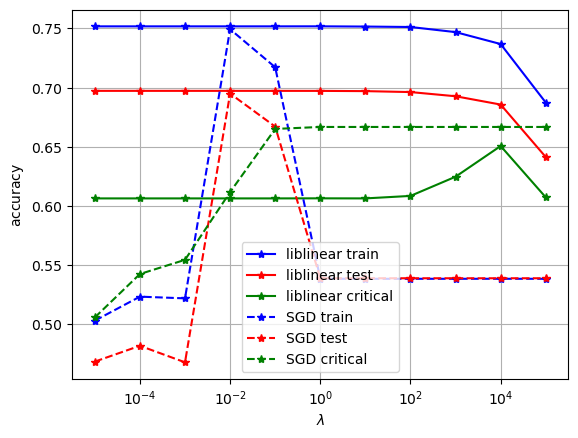

In [20]:
# plot accuracy against regularisation strength
plt.semilogx(lmbdas,train_accuracy,'*-b',label='liblinear train')
plt.semilogx(lmbdas,test_accuracy,'*-r',label='liblinear test')
plt.semilogx(lmbdas,critical_accuracy,'*-g',label='liblinear critical')

plt.semilogx(lmbdas,train_accuracy_SGD,'*--b',label='SGD train')
plt.semilogx(lmbdas,test_accuracy_SGD,'*--r',label='SGD test')
plt.semilogx(lmbdas,critical_accuracy_SGD,'*--g',label='SGD critical')

plt.xlabel('$\\lambda$')
plt.ylabel('$\\mathrm{accuracy}$')

plt.grid()
plt.legend()


plt.show()

### *Dependance of the sample size*

In [24]:
#define number of different sample sizes
n_sets = 8
n_configs = 600
###### define ML parameters
num_classes=2
train_to_test_ratio=0.5 # training samples

# define regularisation parameter
lmbda=1e-1

# preallocate data
train_accuracy=np.zeros(n_sets,np.float64)
test_accuracy=np.zeros(n_sets,np.float64)
critical_accuracy=np.zeros(n_sets,np.float64)

train_accuracy_SGD=np.zeros(n_sets,np.float64)
test_accuracy_SGD=np.zeros(n_sets,np.float64)
critical_accuracy_SGD=np.zeros(n_sets,np.float64)

n_config_T = np.linspace(n_configs,n_sets*n_configs,n_sets)

In [25]:
print('Number of configs per T in total (ordered):', ordered_X.shape[0]/7)
print('Number of configs per T in total (disordered):', disordered_X.shape[0]/6)
print('Number of configs per T in total (critical):', critical_X.shape[0]/3)
print()
print('Number of sets:', n_sets)
print()
print('Number of configs per T in one set:', n_configs)

Number of configs per T in total (ordered): 5400.0
Number of configs per T in total (disordered): 5400.0
Number of configs per T in total (critical): 5400.0

Number of sets: 8

Number of configs per T in one set: 600


In [26]:
ordered_X.shape

(37800, 1600)

In [27]:
#number of configs per T * numer of different T
k_ord = n_configs*7
k_disord = n_configs*6

#loop over sets
for i in range(n_sets):
 
    X=np.concatenate((ordered_X[:k_ord*(i+1)],disordered_X[:k_disord*(i+1)]))
    Y=np.concatenate((ordered_Y[:k_ord*(i+1),2],disordered_Y[:k_disord*(i+1),2]))

    # pick random data points from ordered and disordered states 
    # to create the training and test sets
    X_train,X_test,Y_train,Y_test=train_test_split(X,Y,train_size=train_to_test_ratio,test_size=1.0-train_to_test_ratio)
  

    # define logistic regressor
    logreg=linear_model.LogisticRegression(C=1.0/lmbda,random_state=1,verbose=0,max_iter=1000,tol=1E-5,
                                           solver='liblinear')

    # fit training data
    logreg.fit(X_train, Y_train)

    # check accuracy
    train_accuracy[i]=logreg.score(X_train,Y_train)
    test_accuracy[i]=logreg.score(X_test,Y_test)
    critical_accuracy[i]=logreg.score(critical_X,critical_Y[:,2])
    
    # define SGD-based logistic regression
    logreg_SGD = linear_model.SGDClassifier(loss='log_loss', penalty='l2', alpha=lmbda, max_iter=500, 
                                           shuffle=True, random_state=1, learning_rate='optimal')#100

    # fit training data
    logreg_SGD.fit(X_train,Y_train)

    # check accuracy
    train_accuracy_SGD[i]=logreg_SGD.score(X_train,Y_train)
    test_accuracy_SGD[i]=logreg_SGD.score(X_test,Y_test)
    critical_accuracy_SGD[i]=logreg_SGD.score(critical_X,critical_Y[:,2])
 
    print('number of configs per T:', 600*(i+1))
    
    print(f'finished computing %i/{n_sets} iterations' %(i+1))

number of configs per T: 600
finished computing 1/8 iterations
number of configs per T: 1200
finished computing 2/8 iterations
number of configs per T: 1800
finished computing 3/8 iterations
number of configs per T: 2400
finished computing 4/8 iterations
number of configs per T: 3000
finished computing 5/8 iterations
number of configs per T: 3600
finished computing 6/8 iterations
number of configs per T: 4200
finished computing 7/8 iterations
number of configs per T: 4800
finished computing 8/8 iterations


In [30]:
n_sims = 4

train_accuracy_SGD=np.zeros((n_sims,n_sets),np.float64)
test_accuracy_SGD=np.zeros((n_sims,n_sets),np.float64)
critical_accuracy_SGD=np.zeros((n_sims,n_sets),np.float64)

#number of configs per T * numer of different T
k_ord = n_configs*7
k_disord = n_configs*6

#loop over sims
for j in range(n_sims):
    #loop over sets
    for i in range(n_sets):
        
        X=np.concatenate((ordered_X[:k_ord*(i+1)],disordered_X[:k_disord*(i+1)]))
        Y=np.concatenate((ordered_Y[:k_ord*(i+1),2],disordered_Y[:k_disord*(i+1),2]))

        # pick random data points from ordered and disordered states 
        # to create the training and test sets
        X_train,X_test,Y_train,Y_test=train_test_split(X,Y,train_size=train_to_test_ratio,test_size=1.0-train_to_test_ratio)
    
        # define SGD-based logistic regression
        logreg_SGD = linear_model.SGDClassifier(loss='log_loss', penalty='l2', alpha=lmbda, max_iter=500, 
                                           shuffle=True, random_state=1, learning_rate='optimal')#100

        # fit training data
        logreg_SGD.fit(X_train,Y_train)

        # check accuracy
        train_accuracy_SGD[j,i]=logreg_SGD.score(X_train,Y_train)
        test_accuracy_SGD[j,i]=logreg_SGD.score(X_test,Y_test)
        critical_accuracy_SGD[j,i]=logreg_SGD.score(critical_X,critical_Y[:,2])
 
        
    
    print(f'finished computing %i/{n_sets} sets' %(j+1))

finished computing 1/8 sets
finished computing 2/8 sets
finished computing 3/8 sets
finished computing 4/8 sets


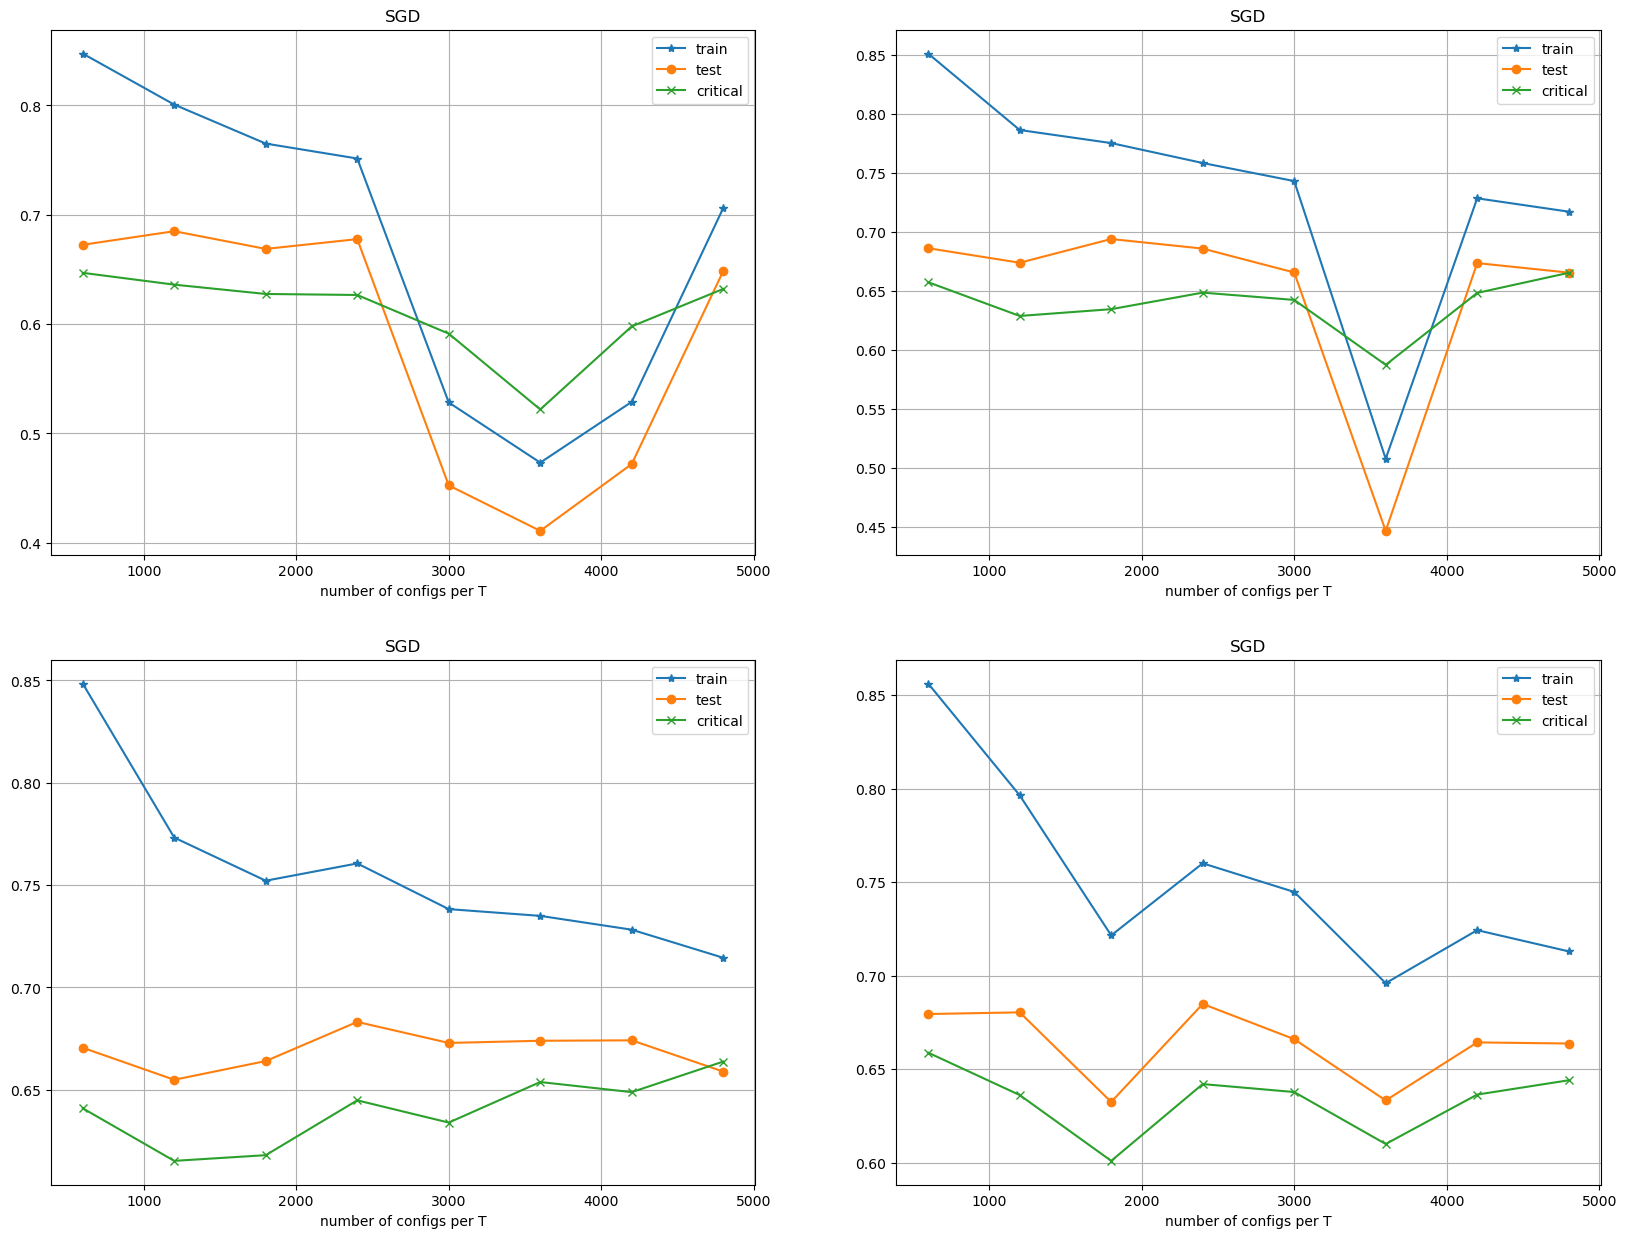

In [31]:
fig, ax = plt.subplots(2,2,figsize=(20,15))

for i, axis in enumerate(ax.flatten()):
    axis.plot(n_config_T,train_accuracy_SGD[i,:],marker = '*',label='train')
    axis.plot(n_config_T,test_accuracy_SGD[i,:],marker = 'o',label='test')
    axis.plot(n_config_T,critical_accuracy_SGD[i,:],marker = 'x',label='critical')

    axis.set_title('SGD')
    axis.set_xlabel('number of configs per T')

    axis.grid()
    axis.legend()

plt.show()

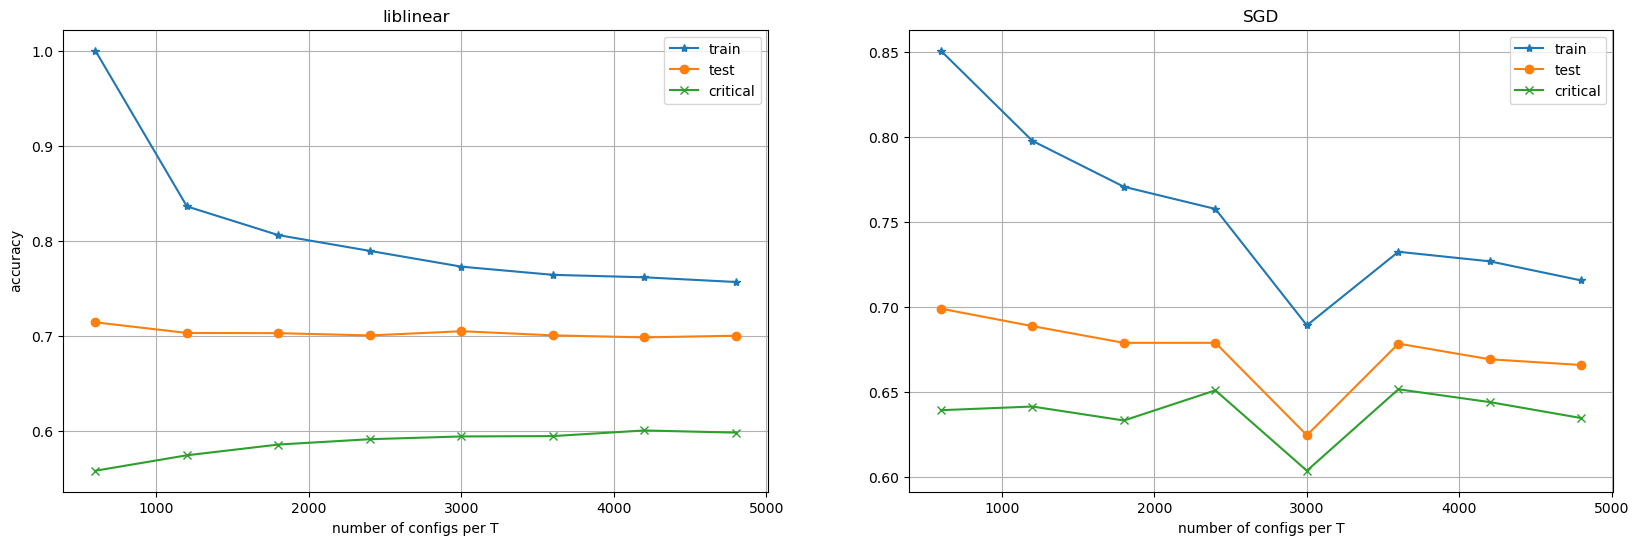

In [28]:
fig, ax = plt.subplots(1,2,figsize=(20,6))

ax[0].plot(n_config_T,train_accuracy,marker = '*',label='train')
ax[0].plot(n_config_T,test_accuracy,marker = 'o',label='test')
ax[0].plot(n_config_T,critical_accuracy,marker = 'x',label='critical')

ax[0].set_title('liblinear')
ax[0].set_xlabel('number of configs per T')
ax[0].set_ylabel('$\\mathrm{accuracy}$')

ax[0].grid()
ax[0].legend()

ax[1].plot(n_config_T,train_accuracy_SGD,marker = '*',label='train')
ax[1].plot(n_config_T,test_accuracy_SGD,marker = 'o',label='test')
ax[1].plot(n_config_T,critical_accuracy_SGD,marker = 'x',label='critical')

ax[1].set_title('SGD')
ax[1].set_xlabel('number of configs per T')

ax[1].grid()
ax[1].legend()

plt.show()

In [41]:
# Read in precalculated data 
data_Linear = np.array(pd.read_csv("LogisticRegressionScaleSetsLinear.csv"))
data_SGD = np.array(pd.read_csv("LogisticRegressionScaleSetsSGD.csv"))

n_config_T = data_Linear[0,:]
train_accuracy = data_Linear[1,:]
test_accuracy = data_Linear[2,:]
critical_accuracy = data_Linear[3,:]

train_accuracy_SGD = data_SGD[1,:]
test_accuracy_SGD = data_SGD[2,:]
critical_accuracy_SGD = data_SGD[3,:]

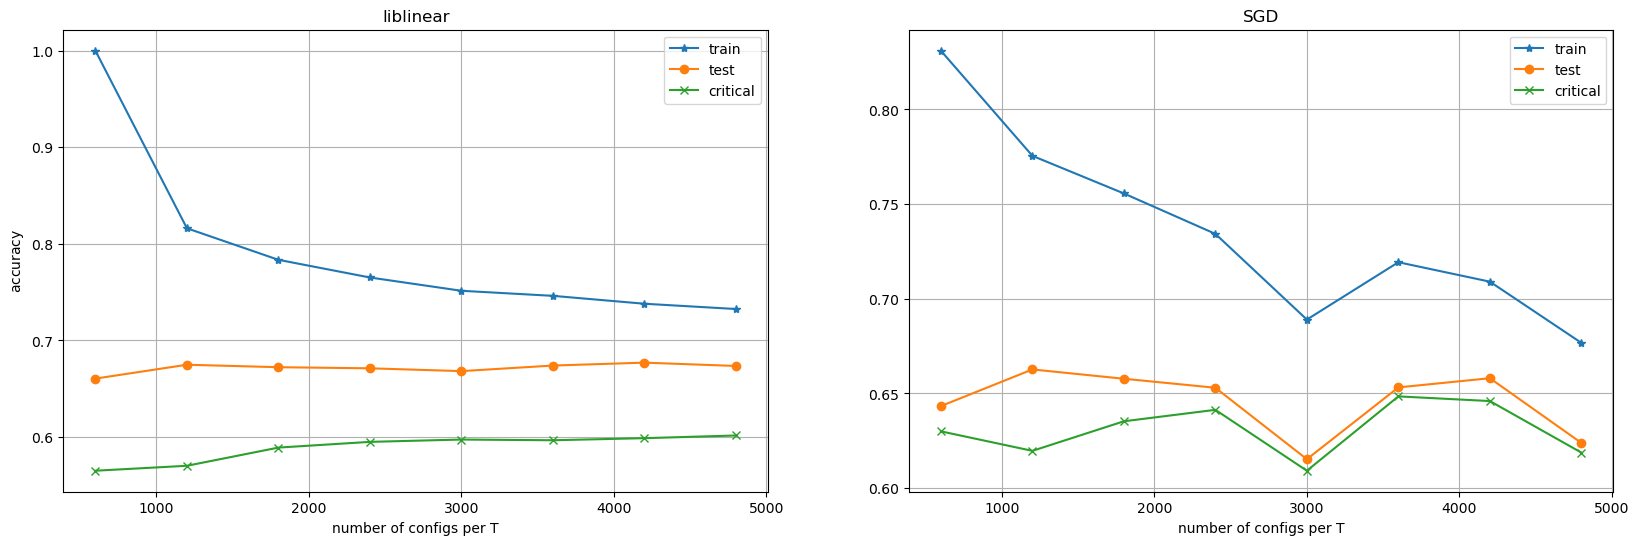

In [54]:
fig, ax = plt.subplots(1,2,figsize=(20,6))

ax[0].plot(n_config_T,train_accuracy,marker = '*',label='train')
ax[0].plot(n_config_T,test_accuracy,marker = 'o',label='test')
ax[0].plot(n_config_T,critical_accuracy,marker = 'x',label='critical')

ax[0].set_title('liblinear')
ax[0].set_xlabel('number of configs per T')
ax[0].set_ylabel('$\\mathrm{accuracy}$')

ax[0].grid()
ax[0].legend()

ax[1].plot(n_config_T,train_accuracy_SGD,marker = '*',label='train')
ax[1].plot(n_config_T,test_accuracy_SGD,marker = 'o',label='test')
ax[1].plot(n_config_T,critical_accuracy_SGD,marker = 'x',label='critical')

ax[1].set_title('SGD')
ax[1].set_xlabel('number of configs per T')

ax[1].grid()
ax[1].legend()

plt.show()

## 2.3 Logistic regression with $y_i = \{T_0, ... T_n\}$

In [14]:
# define training and test data sets
X=np.concatenate((ordered_X,disordered_X,critical_X))
Y=np.concatenate((ordered_Y[:,1],disordered_Y[:,1],critical_Y[:,1]))

#configs per Temperature
n_configs = critical_X.shape[0]/3

In [15]:
###### define ML parameters
num_classes= len(T)
train_to_test_ratio=0.5 # training samples

# pick random data points from ordered and disordered states 
# to create the training and test sets
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,train_size=train_to_test_ratio,test_size=1.0-train_to_test_ratio)

In [16]:
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
print()
print('Number of configs per T in one set:', n_configs)

X_train shape: (43200, 1600)
Y_train shape: (43200,)

43200 train samples
43200 test samples

Number of configs per T in one set: 5400.0


In [17]:
# define regularisation parameter
lmbdas = 1
# preallocate data
train_accuracy=None
test_accuracy=None

In [18]:
# define logistic regressor
logreg=linear_model.LogisticRegression(C=1.0/lmbdas,random_state=1,verbose=0,max_iter=1000,tol=1E-5,
                                           solver='liblinear')

# fit training data
logreg.fit(X_train, Y_train)

# check accuracy
train_accuracy=logreg.score(X_train,Y_train)
test_accuracy=logreg.score(X_test,Y_test)
 

   
print('accuracy: train, test')
print('liblin: %0.4f, %0.4f' %(train_accuracy,test_accuracy))

accuracy: train, test
liblin: 0.2647, 0.1382


In [19]:
X_T=np.concatenate((ordered_X,disordered_X,critical_X))
Y_T=np.concatenate((ordered_Y,disordered_Y,critical_Y))

temp_X = []
temp_Y = []
for i in T:
    ind = np.where(Y_T[:,0] == i)[0]
    temp_X.append(X_T[ind,:])
    temp_Y.append(Y_T[ind,:])

In [20]:
score_per_temp = np.zeros(len(T))
for i in range(len(T)):
    score_per_temp[i] = logreg.score(temp_X[i],temp_Y[i][:,1])

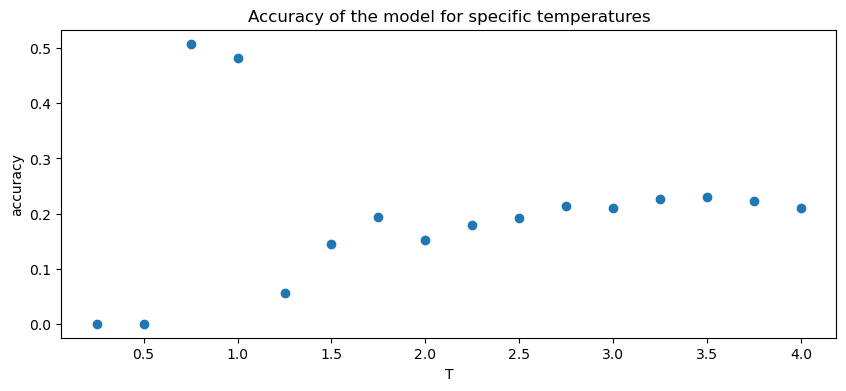

In [21]:
fig, ax = plt.subplots(1, figsize = (10,4))

ax.scatter(T,score_per_temp, label = "linear")
ax.set_xlabel("T")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy of the model for specific temperatures")
plt.show()



In [22]:
predicts = np.empty((len(T),temp_X[0].shape[0]))

for i in range(len(T)):
    for j in range(temp_Y[i].shape[0]):
        predicts[i,j] = logreg.predict([temp_X[i][j,:]])[0]

In [56]:
predicts[0,:].shape

(5400,)

In [71]:
mask = (predicts[1,:] == 2)
configs = [temp_X[1][i,:] for i in range(len(temp_X[0])) if mask[i]]
mask3 = (predicts[1,:] == 3)
configs3 = [temp_X[1][i,:] for i in range(len(temp_X[0])) if mask3[i]]

In [72]:
M = np.sum(configs, axis=1)/N**2
M3 = np.sum(configs3, axis=1)/N**2

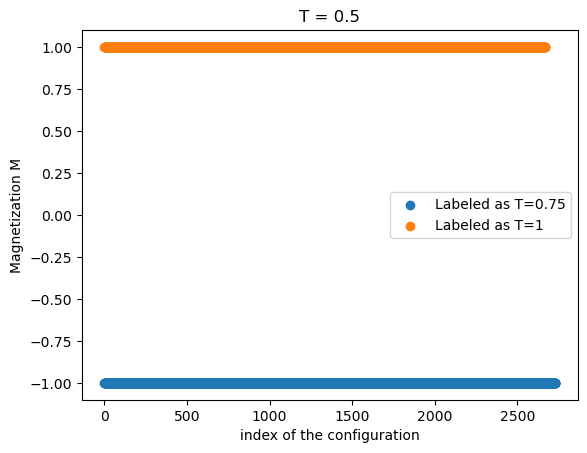

In [74]:
plt.scatter(np.arange(0,len(M),1),M, label="Labeled as T=0.75")
plt.scatter(np.arange(0,len(M3),1),M3, label = "Labeled as T=1")
plt.xlabel("index of the configuration")
plt.ylabel("Magnetization M")
plt.title("T = 0.5")
plt.legend()
plt.show()

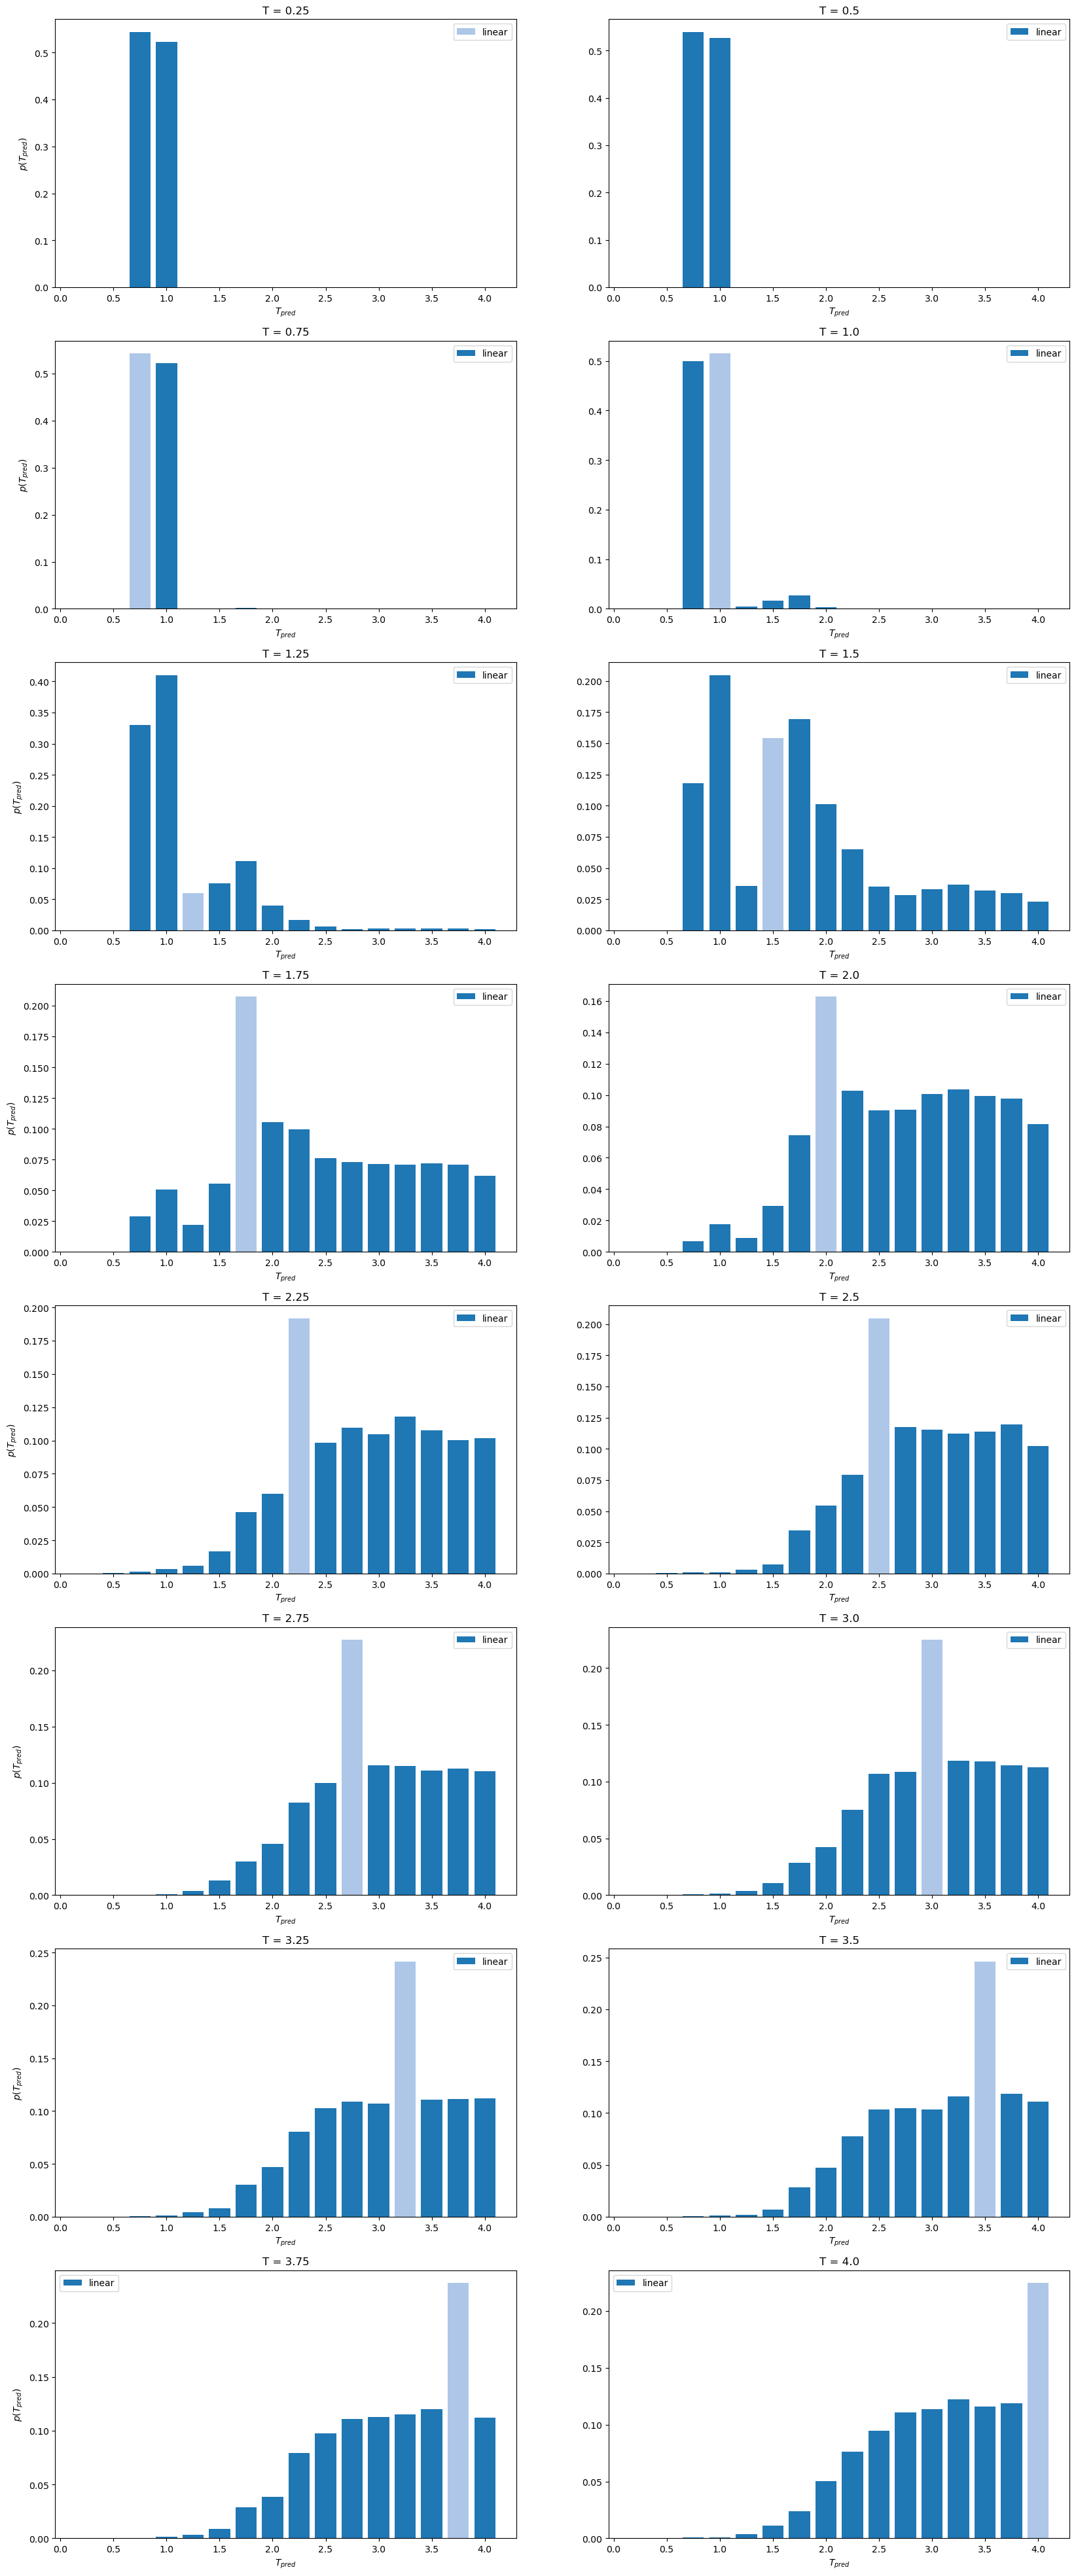

In [75]:
fig,ax = plt.subplots(8,2, figsize = (20,50))
bins = np.arange(16)
cmap = plt.get_cmap('tab20')

for i, axis in enumerate(ax.flatten()):
    c = np.array([cmap(0)] * 16)
    c[i] = cmap(1)
    density, bin_edges = np.histogram(predicts[i,:], 16,range = (0,15), density=True)
    #density_SGD, bin_edges = np.histogram(predicts_SGD[i,:], 16, density=True)
    axis.bar(T,density, width = 0.2, label = "linear", color = c)
    #axis.bar(T,density_SGD, width = 0.2, label = "SGD")
    axis.set_title(f"T = {T[i]}")
    axis.set_xlabel("$T_{pred}$")
    axis.legend()
    if i%2 == 0:
        axis.set_ylabel("$p(T_{pred})$")